In [1]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


def dataframe_to_html(df: pl.DataFrame, columns: list) -> str:
    """
    Convert a Polars DataFrame to an HTML table with specified columns.

    Args:
        df: Polars DataFrame containing the data.
        columns: List of column names to include in the HTML table.

    Returns:
        str: HTML string representing the table.
    """
    html = ["<table border='1'>"]

    html.append("<tr>")
    for col in columns:
        html.append(f"<th>{col}</th>")
    html.append("</tr>")

    for row in df.iter_rows(named=True):
        html.append("<tr>")
        for col in columns:
            value = row[col]
            if col == "image_url":
                html.append(f"<td><img src='{value}' width='100' /></td>")
            else:
                html.append(f"<td>{value}</td>")
        html.append("</tr>")

    html.append("</table>")
    return "\n".join(html)


In [2]:
data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"

In [3]:
train = pl.read_parquet(data_folder + "train.pq")
print("Train:")
print(train.shape)
display(train.head(5))

Train:
(11971437, 5)


user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20


In [4]:
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))
print("Test:")
print(test.shape)
display(test.head(5))

Test:
(185828, 2)


user_id,item_id
str,list[i64]
"""00000377eea48021d3002730d56aca…",[13252]
"""00009ab2ed8cbfceda5a59da409663…",[2328]
"""00009e46d18f223a82b22da38586b6…","[28636, 30197]"
"""0001085188e302fc6b2568de45a5f5…","[2159, 2969, … 33630]"
"""00014c578111090720e20f5705eba0…","[45, 3513, … 33273]"


In [5]:
books = pl.read_parquet(data_folder + "books.pq")
print("Books:")
print(books.shape)
display(books.head(5))

Books:
(34322, 8)


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"


## EDA

In [6]:
books_cleaned = books.with_columns(
    pl.col('series').replace([None], 0).alias('series')
)
books_cleaned

item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"
…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]"
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]"
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]"


In [7]:
books_cleaned = books.with_columns(
    pl.when(
        (pl.col('series').list.len() == 1) & (pl.col('series').list.first().is_null())
    )
    .then(pl.lit(["0"], dtype=pl.List(pl.Utf8)))
    .otherwise(pl.col('series'))
    .alias('series')
)

In [8]:
books_cleaned

item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,"[""0""]","[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,"[""0""]","[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"
…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]"
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]"
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]"


In [9]:
# Calculate the length of each list in the 'series' column
books_with_length = books.with_columns(
    pl.col('series').list.len().alias('series_length')
)

# Find the maximum length
max_length = books_with_length['series_length'].max()

# Filter rows where the list length equals the maximum length
longest_series = books_with_length.filter(
    pl.col('series_length') == max_length
)

# Select relevant columns and display
result = longest_series.select(['item_id', 'series', 'series_length', 'title'])
print(result)

shape: (2, 4)
┌─────────┬─────────────────────────────────┬───────────────┬────────────┐
│ item_id ┆ series                          ┆ series_length ┆ title      │
│ ---     ┆ ---                             ┆ ---           ┆ ---        │
│ i64     ┆ list[str]                       ┆ u32           ┆ str        │
╞═════════╪═════════════════════════════════╪═══════════════╪════════════╡
│ 17220   ┆ ["832282", "1127812", … null]   ┆ 5             ┆ Unleashed  │
│ 19144   ┆ ["824774", "291336", … "558673… ┆ 5             ┆ Mind Games │
└─────────┴─────────────────────────────────┴───────────────┴────────────┘


In [10]:
books_with_length.sort(by='series_length')

item_id,series,tags,title,description,url,image_url,authors,series_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u32
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1
…,…,…,…,…,…,…,…,…
32927,"[""1135762"", ""1135766"", … ""300214""]","[""no-longer-own"", ""want"", … ""on-my-shelf""]","""Timestorm (Tempest, #3)""","""The battle between the Tempest…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""3429117"",""""}]",4
33230,"[""964041"", ""265145"", … ""409278""]","[""currently-reading"", ""buffy-books"", … ""vamps""]","""Halloween Rain (Buffy the Vamp…","""Around Sunnydale, they say a s…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""4522"",""""}, {""27206"",""""}]",4
34218,"[""148726"", ""824020"", … ""824067""]","[""fiction"", ""favorites"", … ""read-in-2014""]","""The Struggle""","""A Love Triangle of Unspeakable…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""50873"",""""}]",4


In [11]:
display(books.head(15))

item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"
…,…,…,…,…,…,…,…
10,[null],"[""audiobook"", ""my-books"", … ""books-to-buy""]","""Dreamology: Sueña. Enamórate. …","""Vibrantly offbeat and utterly …","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""9809970"",""""}]"
11,[null],"[""tween-boys"", ""fiction"", … ""new-j-fiction-spring-2013""]","""Summer On The Moon""","""It is the beginning of summer …","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""194825"",""""}]"
12,"[""226713""]","[""first-in-a-series"", ""fiction"", … ""read-2013""]","""Hemlock""","""MACKENZIE AND AMY WERE BEST FR…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4124788"",""""}]"


# EDA interactions

In [12]:
train.select('rating').to_series().describe()

statistic,value
str,f64
"""count""",1.1971437e7
"""null_count""",0.0
"""mean""",1.432679
"""std""",1.997666
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",4.0
"""max""",5.0


5 балльная шкала по рейтингу

In [13]:
train

user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20
…,…,…,…,…
"""41b6ce17e6716721ba0a3364730d60…",12298,false,0,2016-12-10 02:45:58
"""31afc6f51ab44c5f886dbfa497c241…",6273,false,0,2016-12-10 02:45:59
"""cff0631d0dae40675e525f008aac1d…",960,true,5,2016-12-10 02:46:10


перевести is_read в 0 и 1

In [14]:
# Convert is_read from boolean to integer (true -> 1, false -> 0)
train = train.with_columns(
    pl.col('is_read').cast(pl.Int8).alias('is_read')
)
train.select('is_read').to_series().describe()

statistic,value
str,f64
"""count""",1.1971437e7
"""null_count""",0.0
"""mean""",0.391888
"""std""",0.488172
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",1.0
"""max""",1.0


In [37]:
train.describe()

statistic,user_id,item_id,is_read,rating,date_added
str,str,f64,f64,f64,str
"""count""","""11971437""",1.1971437e7,1.1971437e7,1.1971437e7,"""11971437"""
"""null_count""","""0""",0.0,0.0,0.0,"""0"""
"""mean""",null,16913.768205,0.391888,1.432679,"""2015-08-27 03:50:02.012039"""
"""std""",null,9950.337952,0.488172,1.997666,null
"""min""","""00000377eea48021d3002730d56aca…",0.0,0.0,0.0,"""2014-05-15 12:51:13"""
"""25%""",null,8303.0,0.0,0.0,"""2015-01-10 06:50:53"""
"""50%""",null,16739.0,0.0,0.0,"""2015-08-31 04:22:39"""
"""75%""",null,25849.0,1.0,4.0,"""2016-04-08 13:04:47"""
"""max""","""fffff8a718843c0e11dfd93fb41c12…",34321.0,1.0,5.0,"""2016-12-10 02:46:36"""


In [15]:
train

user_id,item_id,is_read,rating,date_added
str,i64,i8,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,0,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,0,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,0,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,0,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,0,0,2014-05-15 12:51:20
…,…,…,…,…
"""41b6ce17e6716721ba0a3364730d60…",12298,0,0,2016-12-10 02:45:58
"""31afc6f51ab44c5f886dbfa497c241…",6273,0,0,2016-12-10 02:45:59
"""cff0631d0dae40675e525f008aac1d…",960,1,5,2016-12-10 02:46:10


In [24]:
train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)

/tmp/ipykernel_1790/2978319012.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)


item_id,count
i64,u32
4058,91558
15514,88038
18150,76860
30197,65033
33370,59835
…,…
19394,1
6901,1
31419,1


/tmp/ipykernel_1790/830197745.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  count_data = train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)


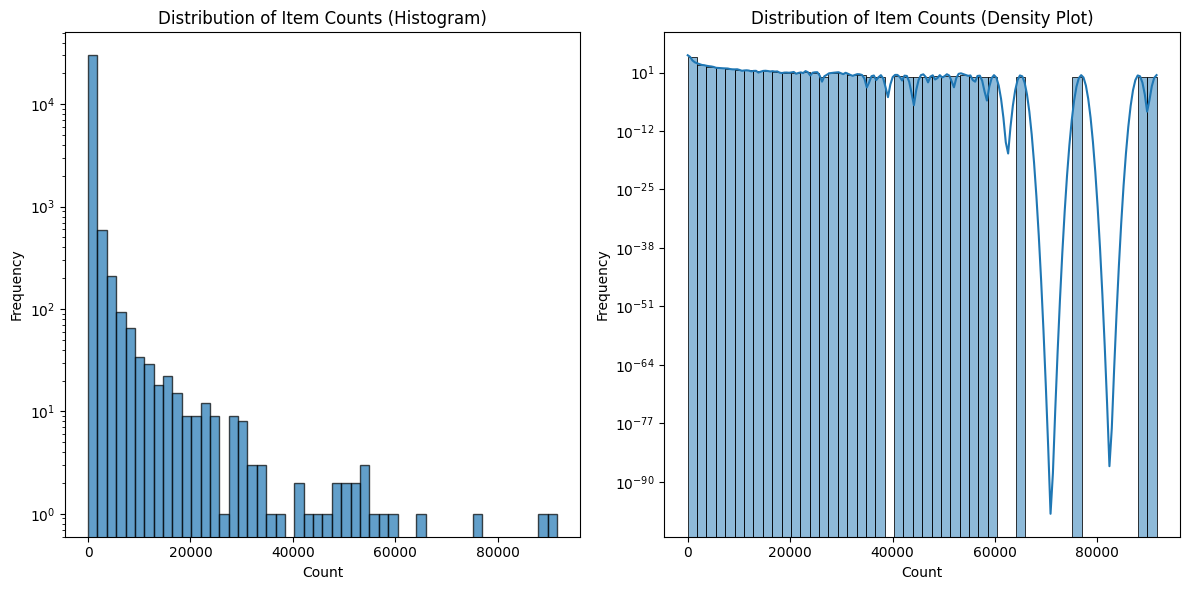

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)

# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['count'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1790/228519227.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  count_data = train.group_by('user_id').agg(pl.count().alias('count')).sort(by='count', descending=True)


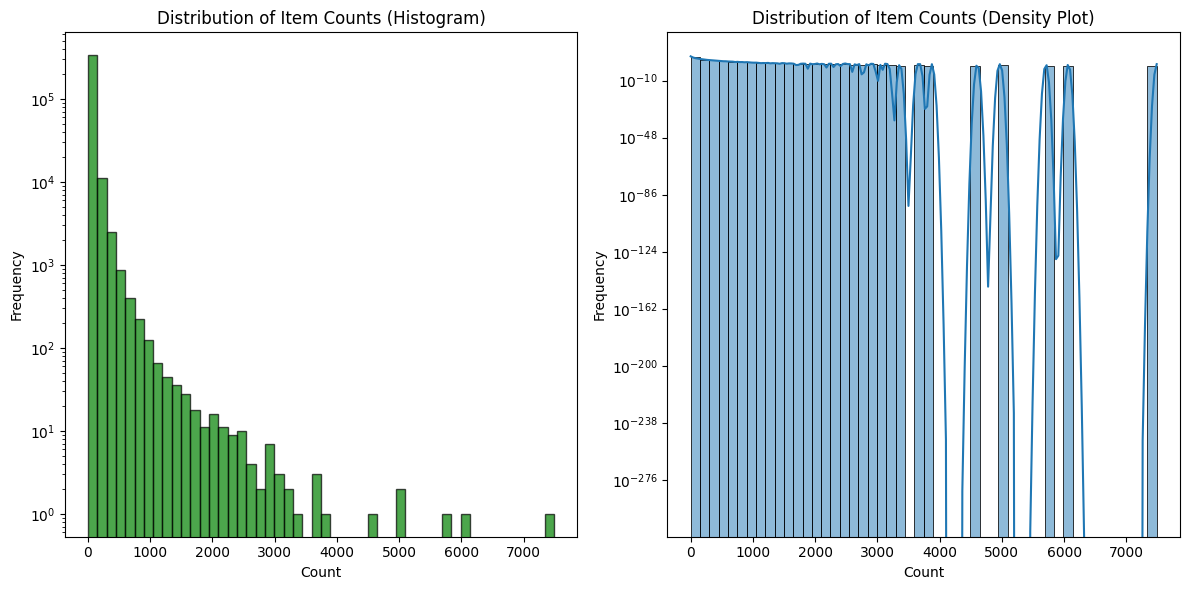

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = train.group_by('user_id').agg(pl.count().alias('count')).sort(by='count', descending=True)

# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['count'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of User Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

**Как я понимаю интеракции тут** есть взаимодействие юзера и книги, по видимому добавление (тк у нас тут именно date added по которрой идет сортировка), есть поле is_read прочитано или нет, вопрос этим же юзером или нет(если этим то зачем добавлять, если в целом то почему так много непрочитанных книг на сервисе, но с другой стороны у нас же вопрос про холодные айтемы и таких 60%) 


#### Is read

In [18]:
is_read_list = train.select('is_read').to_series().value_counts()
is_read_list.with_columns((pl.col('count')/train.shape[0]).alias('percentage'))

is_read,count,percentage
i8,u32,f64
0,7279978,0.608112
1,4691459,0.391888


#### rating

In [19]:
rating_list = train.select('rating').to_series().value_counts()
rating_list.with_columns((pl.col('count')/train.shape[0]).alias('percentage'))

rating,count,percentage
i64,u32,f64
3,906917,0.075757
0,7649845,0.639008
1,88344,0.00738
2,257190,0.021484
4,1517959,0.126798
5,1551182,0.129574


#### date_added

In [27]:
print(
    train.select(
        pl.col("date_added").min().alias("date_added_min"),
        pl.col("date_added").max().alias("date_added_max")
    )
)


shape: (1, 2)
┌─────────────────────┬─────────────────────┐
│ date_added_min      ┆ date_added_max      │
│ ---                 ┆ ---                 │
│ datetime[μs]        ┆ datetime[μs]        │
╞═════════════════════╪═════════════════════╡
│ 2014-05-15 12:51:13 ┆ 2016-12-10 02:46:36 │
└─────────────────────┴─────────────────────┘


In [28]:
date_train = train.with_columns(
    pl.col("date_added").dt.month().alias("month"),
    pl.col("date_added").dt.week().alias("week"),
    pl.col("date_added").dt.day().alias("day"),
    pl.col("date_added").dt.hour().alias("hour"),
    pl.col("date_added").dt.weekday().alias("weekday")  # 1 = Monday, 7 = Sunday
)


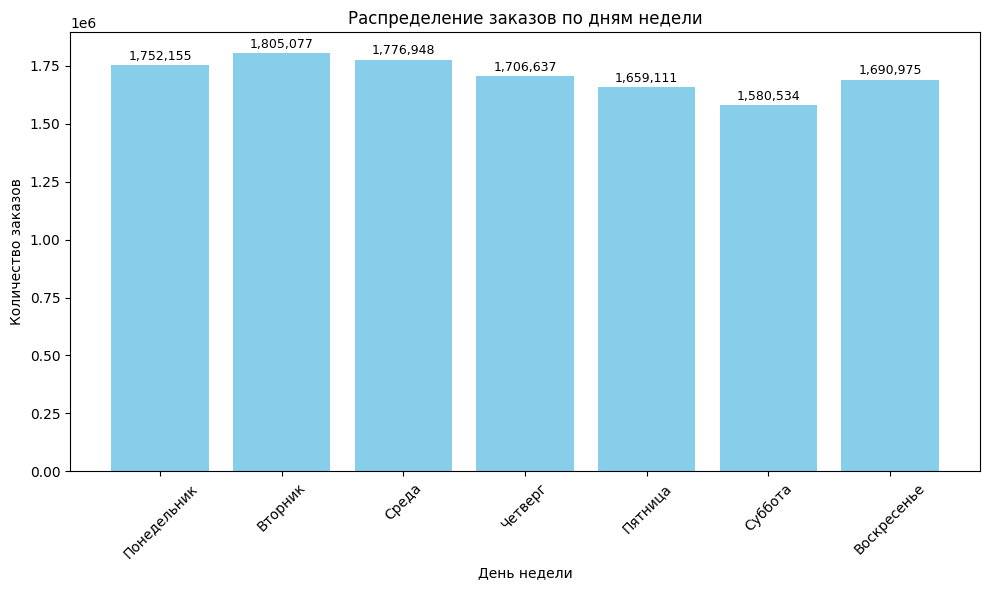

In [29]:
import matplotlib.pyplot as plt

# Get weekday counts
weekday_counts = date_train.select('weekday').to_series().value_counts().sort('weekday')

# Extract data for plotting
weekdays = weekday_counts['weekday'].to_list()
counts = weekday_counts['count'].to_list()

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(weekdays, counts, color='skyblue')

# Customize the plot
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по дням недели')
plt.xticks(weekdays, ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

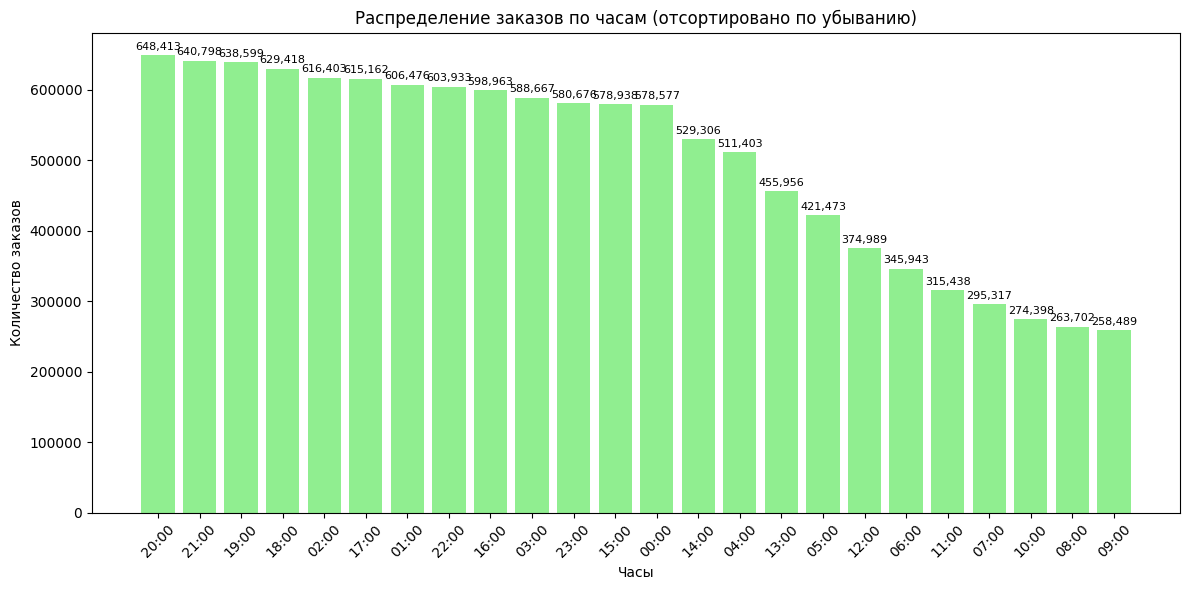

In [30]:
import matplotlib.pyplot as plt

# Get hour counts sorted by count (descending)
hour_counts = (date_train
               .select('hour')
               .to_series()
               .value_counts()
               .sort('count', descending=True))

# Extract data for plotting
hours = hour_counts['hour'].to_list()
counts = hour_counts['count'].to_list()

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(hours)), counts, color='lightgreen')

# Customize the plot
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по часам (отсортировано по убыванию)')
plt.xticks(range(len(hours)), [f'{hour:02d}:00' for hour in hours], rotation=45)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

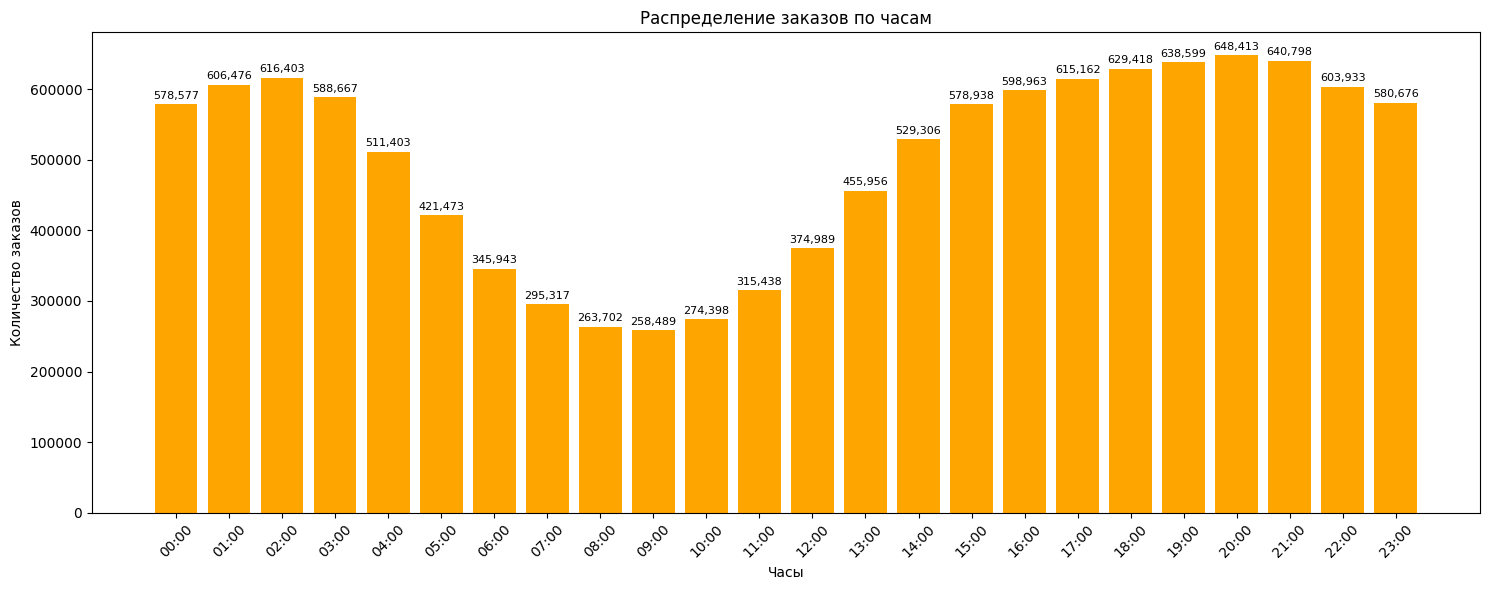

In [31]:
import matplotlib.pyplot as plt

# Get hour counts sorted by hour
hour_counts = (date_train
               .select('hour')
               .to_series()
               .value_counts()
               .sort('hour'))

# Extract data for plotting
hours = hour_counts['hour'].to_list()
counts = hour_counts['count'].to_list()

# Create bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(hours, counts, color='orange', width=0.8)

# Customize the plot
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по часам')
plt.xticks(hours, [f'{hour:02d}:00' for hour in hours], rotation=45)

# Add value labels on bars
for hour, count in zip(hours, counts):
    plt.text(hour, count + 5000, f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

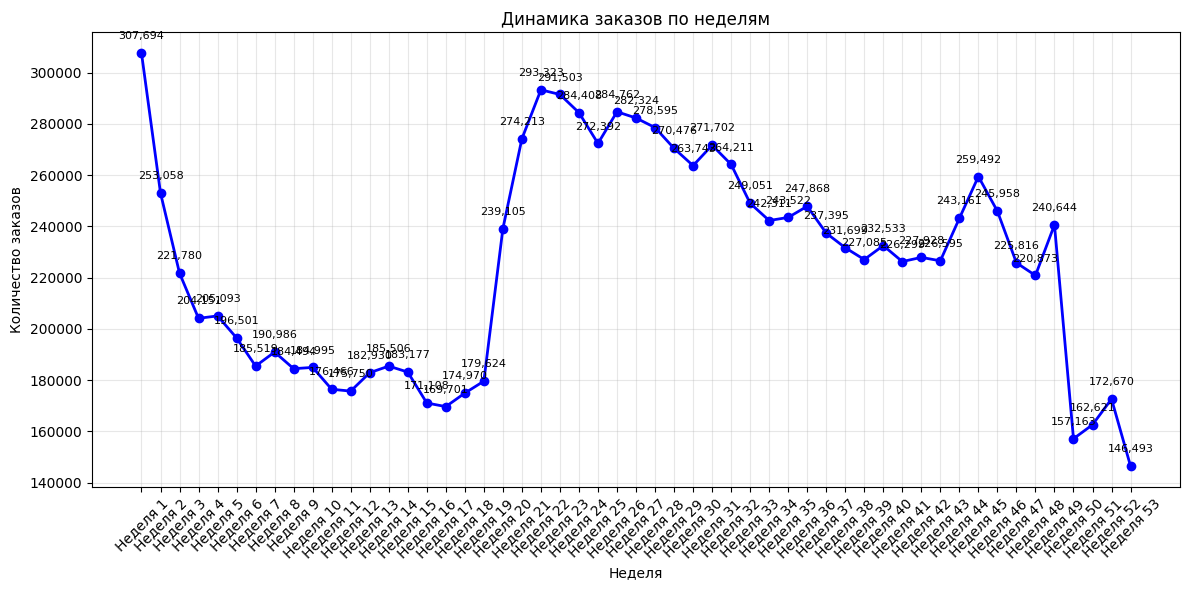

In [32]:
import matplotlib.pyplot as plt

# Get week counts sorted by week
week_counts = (date_train
               .select('week')
               .to_series()
               .value_counts()
               .sort('week'))

# Extract data for plotting
weeks = week_counts['week'].to_list()
counts = week_counts['count'].to_list()

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(weeks, counts, marker='o', linewidth=2, markersize=6, color='blue')

# Customize the plot
plt.xlabel('Неделя')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов по неделям')
plt.grid(True, alpha=0.3)

# Add value labels on points
for week, count in zip(weeks, counts):
    plt.annotate(f'{count:,}', (week, count), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8)

# Set x-axis ticks
plt.xticks(weeks, [f'Неделя {week}' for week in weeks], rotation=45)

plt.tight_layout()
plt.show()

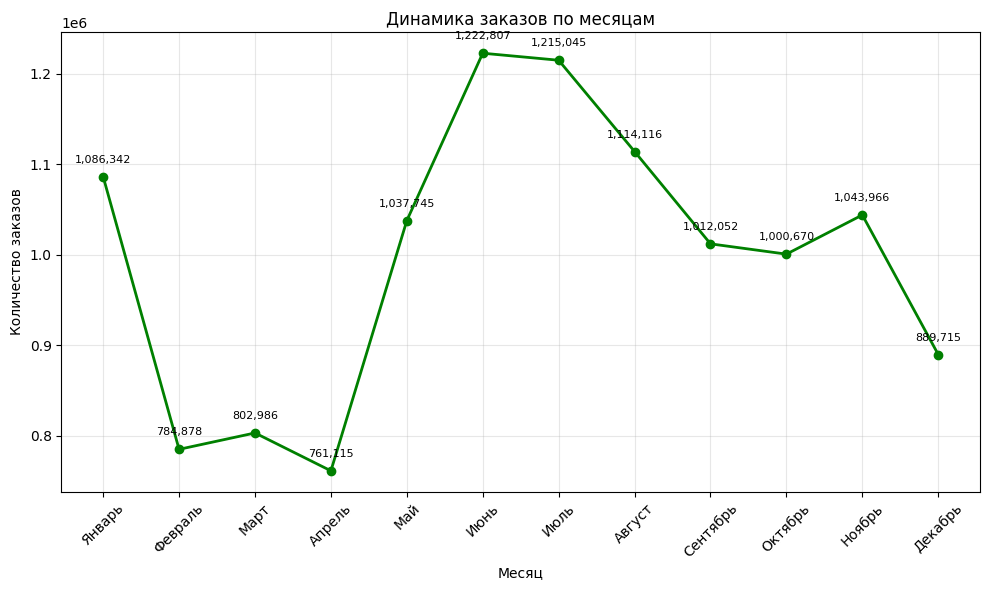

In [33]:
import matplotlib.pyplot as plt

# Get month counts sorted by month
month_counts = (date_train
               .select('month')
               .to_series()
               .value_counts()
               .sort('month'))

# Extract data for plotting
months = month_counts['month'].to_list()
counts = month_counts['count'].to_list()

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(months, counts, marker='o', linewidth=2, markersize=6, color='green')

# Customize the plot
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов по месяцам')
plt.grid(True, alpha=0.3)

# Add value labels on points
for month, count in zip(months, counts):
    plt.annotate(f'{count:,}', (month, count), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8)

# Set x-axis ticks with month names
month_names = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 
               'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
plt.xticks(months, [month_names[m-1] for m in months], rotation=45)

plt.tight_layout()
plt.show()

# EDA Books

In [36]:
books_cleaned


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,"[""0""]","[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,"[""0""]","[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"
…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]"
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]"
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]"


In [49]:
books_cleaned.select('item_id').n_unique()

34322

In [50]:
train.select('item_id').n_unique()

31300

In [38]:
books_cleaned.describe()

statistic,item_id,series,tags,title,description,url,image_url,authors
str,f64,f64,f64,str,str,str,str,f64
"""count""",34322.0,34322.0,34322.0,"""34322""","""34322""","""34322""","""34322""",34322.0
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",0.0
"""mean""",17160.5,null,null,null,null,null,null,null
"""std""",9908.052306,null,null,null,null,null,null,null
"""min""",0.0,null,null,"""""B"" Is for Bad at Getting into…","""""","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…",null
"""25%""",8580.0,null,null,null,null,null,null,null
"""50%""",17161.0,null,null,null,null,null,null,null
"""75%""",25741.0,null,null,null,null,null,null,null
"""max""",34321.0,null,null,"""微微一笑很倾城 [Just One Smile Is Ver…","""~Tales of Ever is an action pa…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…",null


#### description

Здесь все понятно, берем текстовый энкодер и смотрим что и как

#### image_url

Здесь тоже все понятно берем визуальный энкодер и делаем

#### series

In [44]:
books_with_length

item_id,series,tags,title,description,url,image_url,authors,series_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u32
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1
…,…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]",1
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]",1
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]",1


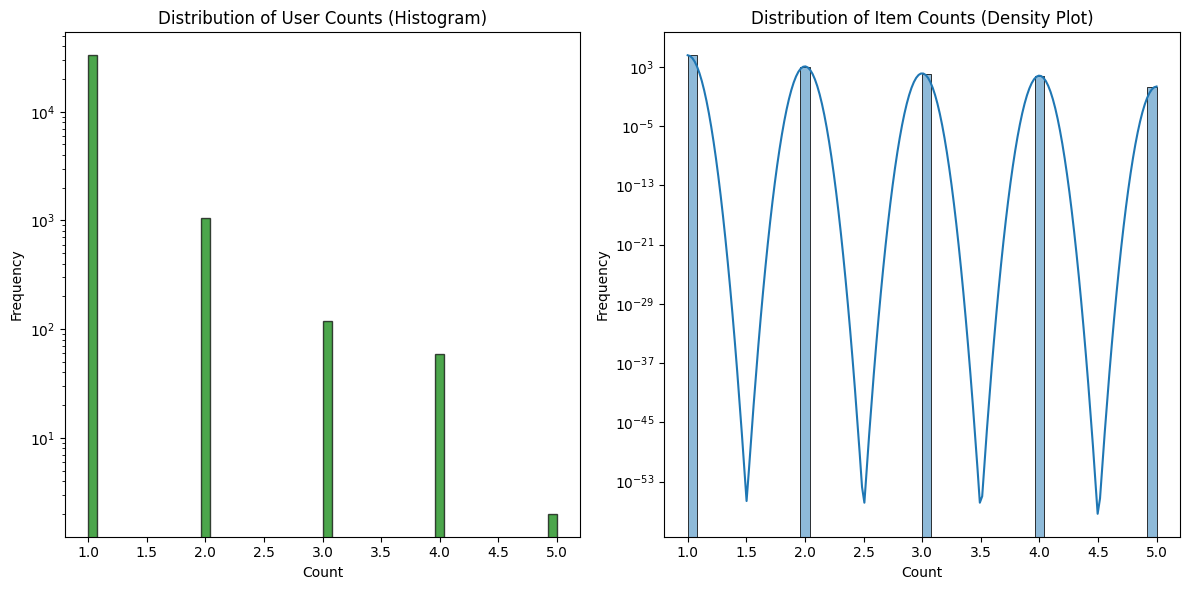

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = books_with_length.select('series_length')
# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['series_length'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of User Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [58]:
print(books_with_length.select([
    pl.col('series_length').min().alias('min_series_len'),
    pl.col('series_length').max().alias('max_series_len'),
    pl.col('authors_length').min().alias('min_authors_len'),
    pl.col('authors_length').max().alias('max_authors_len')
]))

shape: (1, 4)
┌────────────────┬────────────────┬─────────────────┬─────────────────┐
│ min_series_len ┆ max_series_len ┆ min_authors_len ┆ max_authors_len │
│ ---            ┆ ---            ┆ ---             ┆ ---             │
│ u32            ┆ u32            ┆ u32             ┆ u32             │
╞════════════════╪════════════════╪═════════════════╪═════════════════╡
│ 1              ┆ 5              ┆ 1               ┆ 52              │
└────────────────┴────────────────┴─────────────────┴─────────────────┘


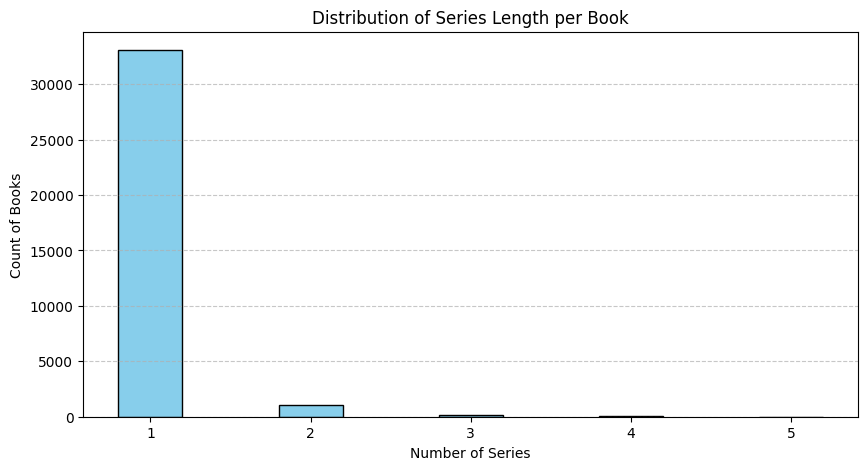

In [62]:
# Compute histogram bins for series_length
series_bins = books_with_length.group_by(
    pl.col('series_length').cast(pl.Int32)
).agg(
    count=pl.len()
).sort('series_length')

# Plot series_length histogram
plt.figure(figsize=(10, 5))
plt.bar(series_bins['series_length'], series_bins['count'], width=0.4, color='skyblue', edgecolor='black')
plt.title('Distribution of Series Length per Book')
plt.xlabel('Number of Series')
plt.ylabel('Count of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute histogram bins for authors_length (log scale for y due to max=52)


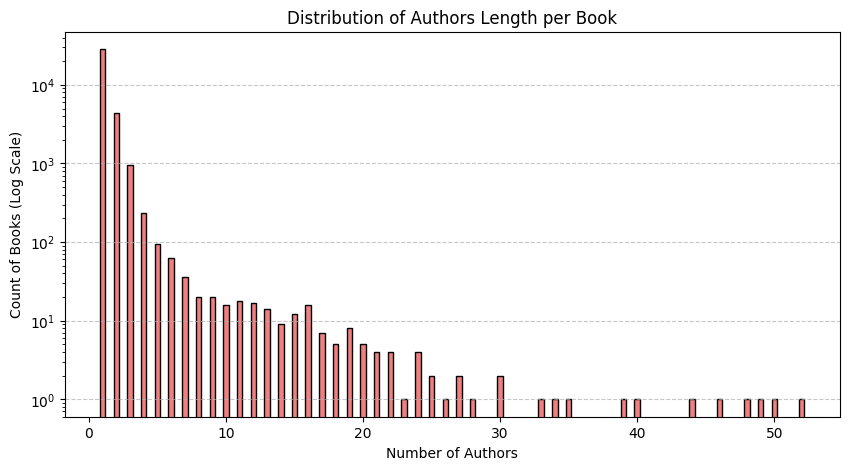

In [63]:
authors_bins = books_with_length.group_by(
    pl.col('authors_length').cast(pl.Int32)
).agg(
    count=pl.len()
).sort('authors_length')

# Plot authors_length histogram (log y-axis for long tail)
plt.figure(figsize=(10, 5))
plt.bar(authors_bins['authors_length'], authors_bins['count'], width=0.4, color='lightcoral', edgecolor='black')
plt.yscale('log')  # Log scale for y-axis
plt.title('Distribution of Authors Length per Book')
plt.xlabel('Number of Authors')
plt.ylabel('Count of Books (Log Scale)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Unique series IDs: 15311
shape: (10, 2)
┌───────────┬────────────┐
│ series_id ┆ book_count │
│ ---       ┆ ---        │
│ str       ┆ u32        │
╞═══════════╪════════════╡
│ null      ┆ 15054      │
│ 302699    ┆ 13         │
│ 145914    ┆ 10         │
│ 154566    ┆ 10         │
│ 152000    ┆ 9          │
│ 207337    ┆ 9          │
│ 935463    ┆ 8          │
│ 205443    ┆ 8          │
│ 164397    ┆ 8          │
│ 204006    ┆ 7          │
└───────────┴────────────┘


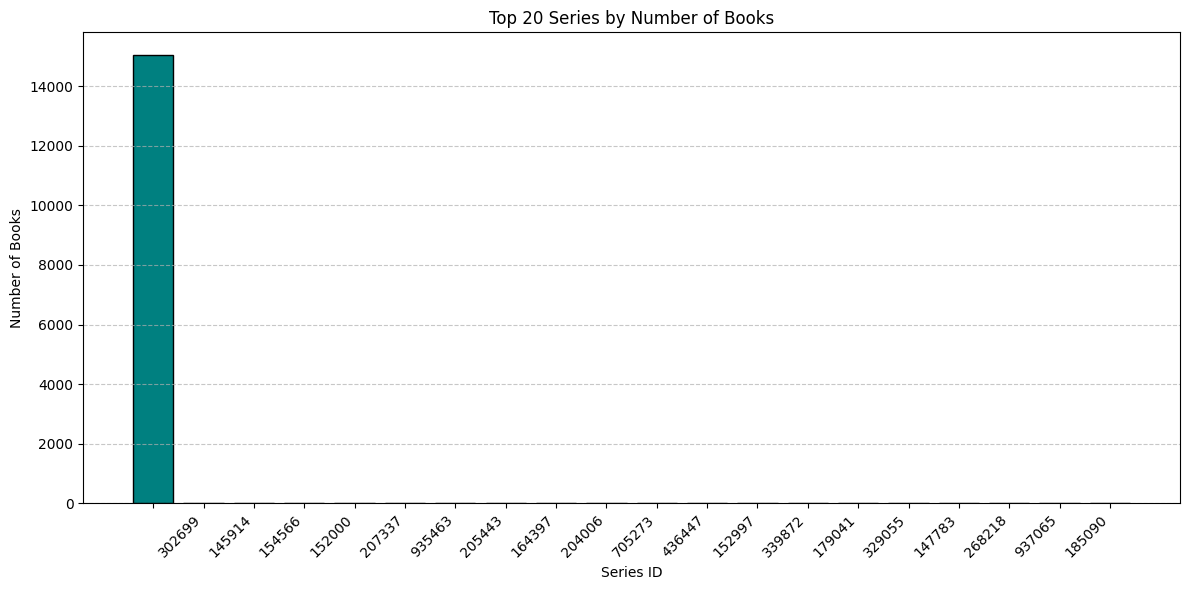

In [64]:
# Explode series and compute frequencies
series_freq = (
    books_with_length.select(pl.col('series').explode().alias('series_id'))
    .group_by('series_id')
    .agg(book_count=pl.len())
    .sort('book_count', descending=True)
)
print(f"Unique series IDs: {series_freq.shape[0]}")
print(series_freq.head(10))  # Top 10 for inspection

# Prepare top 20 for plotting
top_series = series_freq.head(20)

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_series)), top_series['book_count'], color='teal', edgecolor='black')
plt.xticks(range(len(top_series)), top_series['series_id'], rotation=45, ha='right')
plt.title('Top 20 Series by Number of Books')
plt.xlabel('Series ID')
plt.ylabel('Number of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### authors

In [ ]:
books_with_length = books_with_length.with_columns(
    pl.col('authors').list.len().alias('authors_length')
)
books_with_length

item_id,series,tags,title,description,url,image_url,authors,series_length,authors_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u32,u32
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1,1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1,1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1,1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1,1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1,1
…,…,…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]",1,1
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]",1,1
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]",1,1


In [48]:
books_with_length.sort(by='authors_length')

item_id,series,tags,title,description,url,image_url,authors,series_length,authors_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u32,u32
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1,1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1,1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1,1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1,1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1,1
…,…,…,…,…,…,…,…,…,…
10189,"[""824965"", ""824968"", … null]","[""you-should-get-it"", ""read-2012"", … ""2018-tbr""]","""After""","""If the melt-down, flood, plagu…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4018722"",""Contributor""}, {""58011"",""Contributor""}, … {""19305"",""""}]",4,46
2088,[null],"[""china"", ""japan-japanese"", … ""to-buy""]","""Tomo: Friendship through Ficti…","""This aptly named fiction antho…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""6583722"",""Contributor""}, {""68794"",""Contributor""}, … {""495801"",""Illustrator""}]",1,48
17016,[null],"[""bc1"", ""anthology"", … ""novellas-inspiration""]","""Horror Stories""","""Perfect for Halloween -- a chi…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4953"",""Contributor""}, {""209"",""""}, … {""115840"",""Contributor""}]",1,49


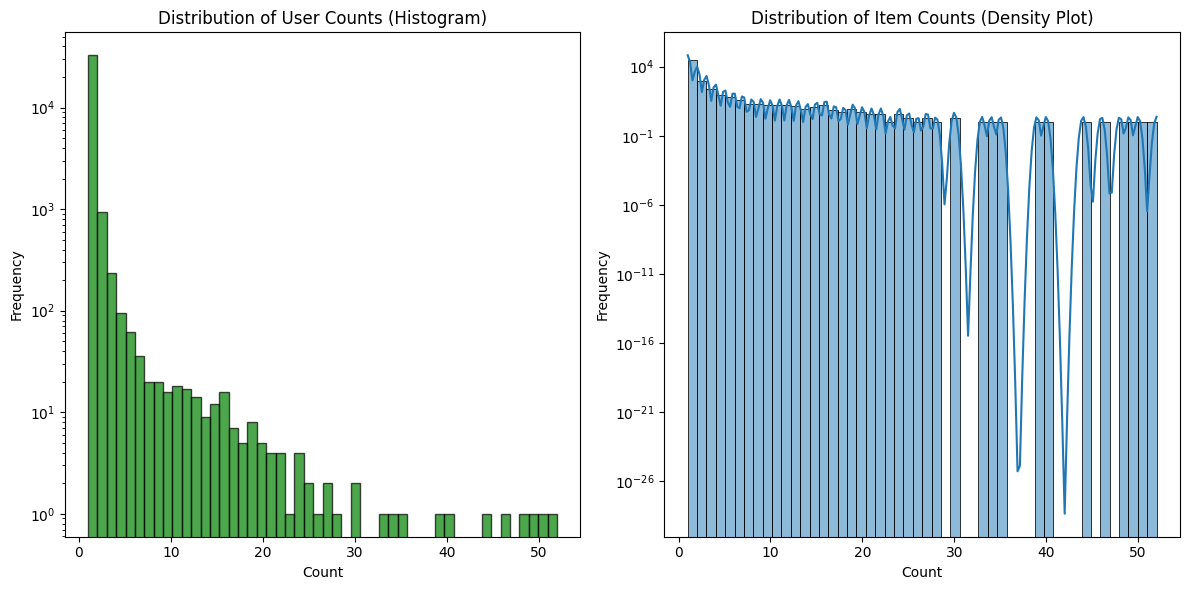

In [47]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = books_with_length.select('authors_length')
# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['authors_length'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of User Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [68]:
# # Explode authors and unnest struct
# authors_exploded = books_with_length.select(
#     pl.col('authors').list.eval(
#         pl.struct(
#             pl.element().struct.field('_0').alias('author_id'),
#             pl.element().struct.field('_1').alias('role')
#         )
#     ).explode().alias('author_info')
# ).explode('author_info').unnest('author_info')
# Explode authors and unnest struct
authors_exploded = books_with_length.select(
    pl.col('authors').list.eval(
        pl.struct(
            pl.element().struct.field('author_id').alias('author_id'),
            pl.element().struct.field('role').alias('role')
        )
    ).explode().alias('author_info')
).explode('author_info').unnest('author_info')
# Author frequencies
author_freq = (
    authors_exploded.group_by('author_id')
    .agg(book_count=pl.len())
    .sort('book_count', descending=True)
)
print(f"Unique author IDs: {author_freq.shape[0]}")
print(author_freq.head(10))

# Bar chart for top 20 authors
top_authors = author_freq.head(20)
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_authors)), top_authors['book_count'], color='navy', edgecolor='black')
plt.xticks(range(len(top_authors)), top_authors['author_id'], rotation=45, ha='right')
plt.title('Top 20 Authors by Number of Books')
plt.xlabel('Author ID')
plt.ylabel('Number of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



InvalidOperationError: `explode` operation not supported for dtype `struct[2]`

In [69]:
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

# Inspect the schema of the authors struct
print(books_with_length['authors'].head(1).list.first().struct.schema)

Schema([('author_id', String), ('role', String)])


In [71]:
# Confirm DataFrame size
print(f"DataFrame shape: {books_with_length.shape}")

# Check for empty or null authors lists
print(books_with_length.select([
    pl.col('authors').is_null().sum().alias('null_authors'),
    pl.col('authors').list.len().eq(0).sum().alias('empty_authors'),
    pl.col('authors').list.len().max().alias('max_authors_length')
]))

DataFrame shape: (34322, 10)
shape: (1, 3)
┌──────────────┬───────────────┬────────────────────┐
│ null_authors ┆ empty_authors ┆ max_authors_length │
│ ---          ┆ ---           ┆ ---                │
│ u32          ┆ u32           ┆ u32                │
╞══════════════╪═══════════════╪════════════════════╡
│ 0            ┆ 0             ┆ 52                 │
└──────────────┴───────────────┴────────────────────┘


In [72]:
# Create a DataFrame with exploded authors
authors_exploded = books_with_length.select([
    pl.col('item_id'),
    pl.col('authors').list.eval(
        pl.struct(
            pl.element().struct.field('author_id').alias('author_id'),
            pl.element().struct.field('role').alias('role')
        )
    ).alias('author_info')
]).explode('author_info').unnest('author_info')

# Verify
print(authors_exploded.head(5))
print(f"Total author entries: {authors_exploded.shape[0]}")

shape: (5, 3)
┌─────────┬───────────┬──────┐
│ item_id ┆ author_id ┆ role │
│ ---     ┆ ---       ┆ ---  │
│ i64     ┆ str       ┆ str  │
╞═════════╪═══════════╪══════╡
│ 0       ┆ 1879494   ┆      │
│ 1       ┆ 21740     ┆      │
│ 2       ┆ 18946     ┆      │
│ 3       ┆ 4605      ┆      │
│ 4       ┆ 792676    ┆      │
└─────────┴───────────┴──────┘
Total author entries: 45058


shape: (141, 2)
┌───────────────────┬───────┐
│ role              ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│                   ┆ 39205 │
│ Narrator          ┆ 2040  │
│ Contributor       ┆ 891   │
│ Illustrator       ┆ 494   │
│ Reading           ┆ 460   │
│ …                 ┆ …     │
│ Narratpr          ┆ 1     │
│ voice actors      ┆ 1     │
│ Cover Photography ┆ 1     │
│ psuedonym         ┆ 1     │
│ mtrjm             ┆ 1     │
└───────────────────┴───────┘


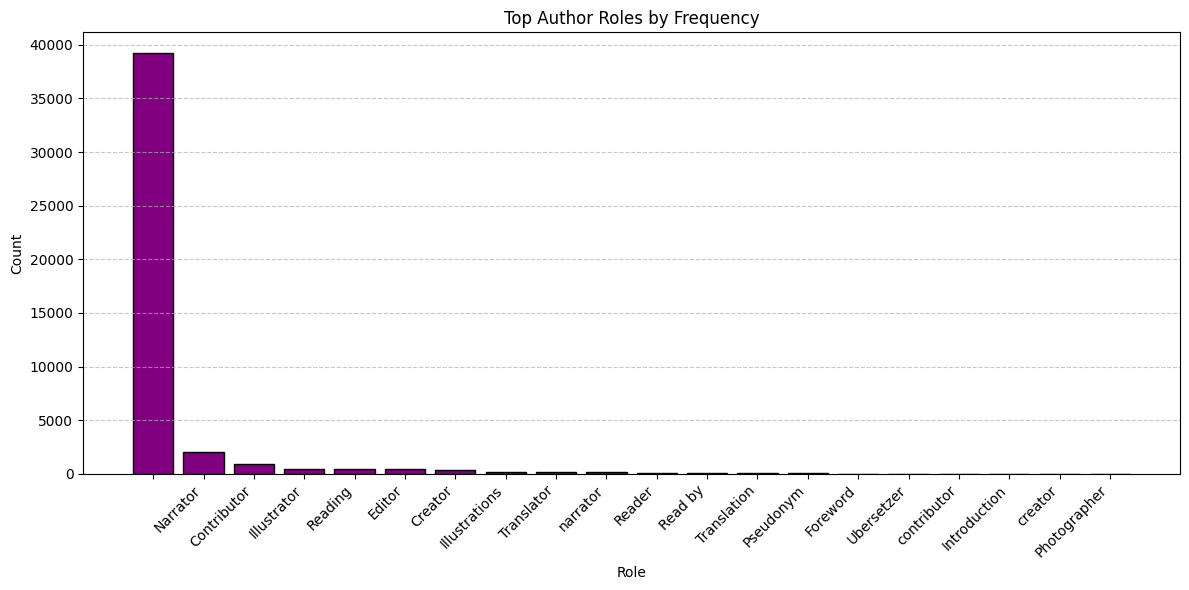

In [73]:
# Role distribution
role_freq = (
    authors_exploded.group_by('role')
    .agg(count=pl.len())
    .sort('count', descending=True)
)
print(role_freq)

# Pie chart for roles if <10, else bar
if role_freq.shape[0] <= 10:
    plt.figure(figsize=(8, 8))
    plt.pie(role_freq['count'], labels=role_freq['role'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(role_freq))))
    plt.title('Distribution of Author Roles')
    plt.show()
else:
    top_roles = role_freq.head(20)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_roles)), top_roles['count'], color='purple', edgecolor='black')
    plt.xticks(range(len(top_roles)), top_roles['role'], rotation=45, ha='right')
    plt.title('Top Author Roles by Frequency')
    plt.xlabel('Role')
    plt.ylabel('Count')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### title

In [54]:
import polars as pl

# Get the most popular items (top 10 as an example)
top_items = (train
             .group_by('item_id')
             .agg(pl.count().alias('count'))
             .sort(by='count', descending=True)
             .head(10))

# Join with books DataFrame to get the descriptions
popular_books_with_info = (top_items
                          .join(books_cleaned, on='item_id', how='left')
                          .select(['item_id', 'count', 'title', 'authors', 'description']))

# Display the results
print(popular_books_with_info)

# If you want to see more columns or export to pandas for better display:
# popular_books_df = popular_books_with_info.to_pandas()

# # Pretty print the results
# for idx, row in popular_books_df.iterrows():
#     print(f"\nRank {idx + 1}:")
#     print(f"Item ID: {row['item_id']}")
#     print(f"Count: {row['count']:,}")
#     print(f"Title: {row['title']}")
#     print(f"Authors: {row['authors']}")
#     print(f"Description: {row['description'][:200]}..." if len(str(row['description'])) > 200 else f"Description: {row['description']}")
#     print("-" * 80)

/tmp/ipykernel_1790/3757600577.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('count'))


shape: (10, 5)
┌─────────┬───────┬──────────────────────────┬──────────────────────────┬──────────────────────────┐
│ item_id ┆ count ┆ title                    ┆ authors                  ┆ description              │
│ ---     ┆ ---   ┆ ---                      ┆ ---                      ┆ ---                      │
│ i64     ┆ u32   ┆ str                      ┆ list[struct[2]]          ┆ str                      │
╞═════════╪═══════╪══════════════════════════╪══════════════════════════╪══════════════════════════╡
│ 4058    ┆ 91558 ┆ The Fault in Our Stars   ┆ [{"3164289","Narrator"}, ┆ Despite the              │
│         ┆       ┆                          ┆ {"140…                   ┆ tumour-shrinking m…      │
│ 15514   ┆ 88038 ┆ The Hunger Games (The    ┆ [{"153394",""},          ┆ Winning will make you    │
│         ┆       ┆ Hunger G…                ┆ {"899110","Nar…          ┆ famous.                  │
│         ┆       ┆                          ┆                          ┆ … 

In [53]:
popular_books_with_info.select('title').head(20)

title
str
"""The Fault in Our Stars"""
"""The Hunger Games (The Hunger G…"
"""Divergent (Divergent, #1)"""
"""Red Queen (Red Queen, #1)"""
"""Eleanor & Park"""
"""We Were Liars"""
"""Catching Fire (The Hunger Game…"
"""Cinder (The Lunar Chronicles, …"
"""Mockingjay (The Hunger Games, …"


Жанров тут нет но можно добавить, по сути кластеризация эмбеддингов (тайтла и описания) == получение жанра
**Future work** можно попробовать соединять название и описание, можно держать их отдельно

#### tags

In [ ]:
# tags_as_strings = books["tags"].map_elements(lambda x: " ".join(x), return_dtype=pl.String)

# vectorizer = CountVectorizer(min_df=0.2, max_df=0.8, max_features=32)
# X = vectorizer.fit_transform(tags_as_strings)
# embeddings = normalize(X.toarray()).tolist()

# books = books.with_columns(
#     pl.Series("embedding_tags", embeddings)
# )
# display(books.head())

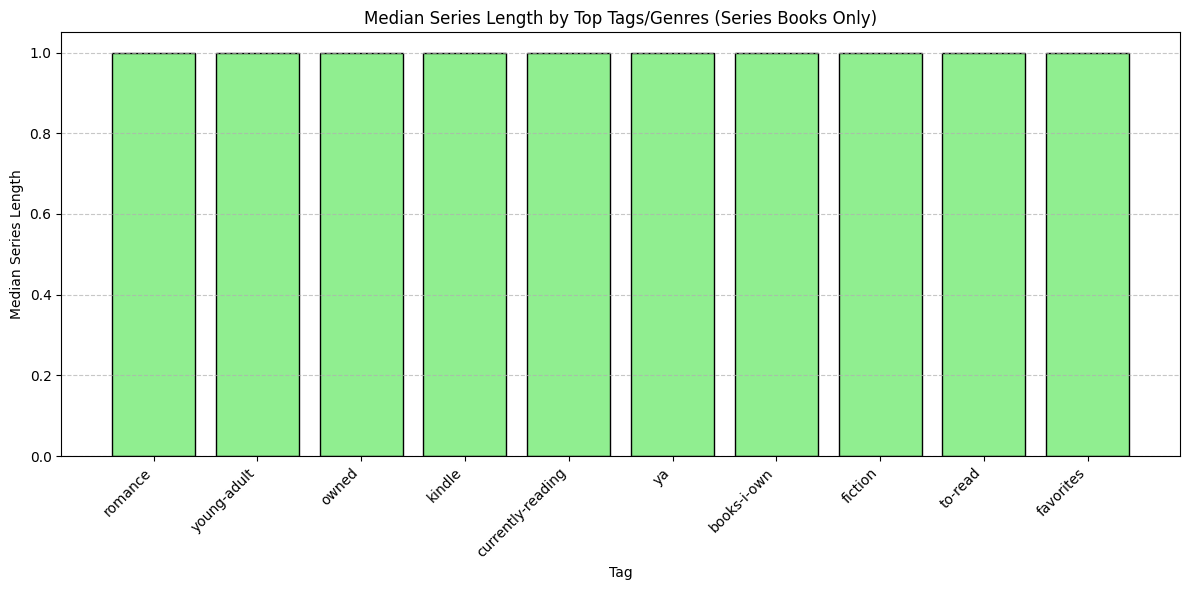

In [75]:
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

# Filter for books with series_length > 0
df_series = books_with_length.filter(pl.col('series_length') > 0)

# Get top 10 tags by frequency, filtered to include series-related tags if possible
common_tags = (
    df_series.select(pl.col('tags').explode().alias('tag'))
    .group_by('tag')
    .agg(count=pl.len())
    .sort('count', descending=True)
    .head(10)
)['tag']

# Compute median series_length per tag
tag_series_length = (
    df_series.explode('tags')
    .filter(pl.col('tags').is_in(common_tags))
    .group_by('tags')
    .agg(median_length=pl.col('series_length').median())
    .sort('median_length', descending=True)
)

# Bar chart of median series_length by tag
plt.figure(figsize=(12, 6))
plt.bar(range(len(tag_series_length)), tag_series_length['median_length'], color='lightgreen', edgecolor='black')
plt.xticks(range(len(tag_series_length)), tag_series_length['tags'], rotation=45, ha='right')
plt.title('Median Series Length by Top Tags/Genres (Series Books Only)')
plt.xlabel('Tag')
plt.ylabel('Median Series Length')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Log scale if median lengths vary widely
if tag_series_length['median_length'].max() > 10:  # Adjust threshold as needed
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(tag_series_length)), tag_series_length['median_length'], color='lightgreen', edgecolor='black')
    plt.yscale('log')
    plt.xticks(range(len(tag_series_length)), tag_series_length['tags'], rotation=45, ha='right')
    plt.title('Median Series Length by Top Tags/Genres (Log Scale, Series Books Only)')
    plt.xlabel('Tag')
    plt.ylabel('Median Series Length (Log Scale)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

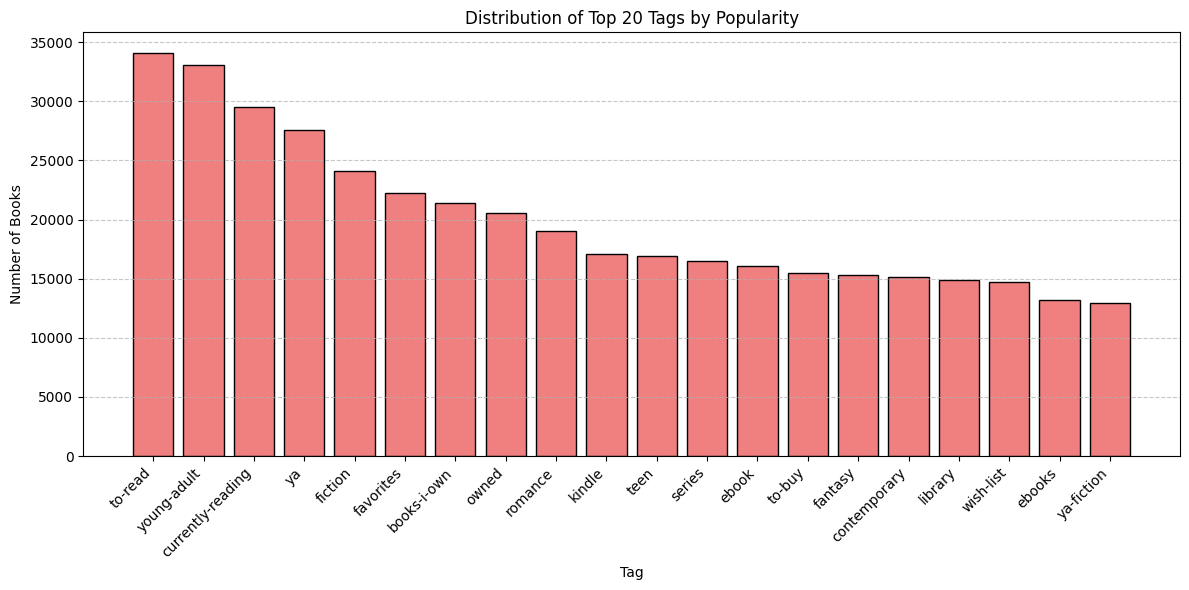

shape: (20, 2)
┌───────────────────┬───────┐
│ tag               ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ to-read           ┆ 34125 │
│ young-adult       ┆ 33110 │
│ currently-reading ┆ 29492 │
│ ya                ┆ 27595 │
│ fiction           ┆ 24100 │
│ …                 ┆ …     │
│ contemporary      ┆ 15121 │
│ library           ┆ 14862 │
│ wish-list         ┆ 14744 │
│ ebooks            ┆ 13175 │
│ ya-fiction        ┆ 12920 │
└───────────────────┴───────┘


In [76]:
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

# Compute tag frequencies
tag_freq = (
    books_with_length.select(pl.col('tags').explode().alias('tag'))
    .group_by('tag')
    .agg(count=pl.len())
    .sort('count', descending=True)
)

# Select top 20 tags for visualization
top_tags = tag_freq.head(20)

# Bar chart of tag popularity
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_tags)), top_tags['count'], color='lightcoral', edgecolor='black')
plt.xticks(range(len(top_tags)), top_tags['tag'], rotation=45, ha='right')
plt.title('Distribution of Top 20 Tags by Popularity')
plt.xlabel('Tag')
plt.ylabel('Number of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Print top 20 tags with counts for reference
print(top_tags)